In [1]:
import numpy as np
import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing') 
import matplotlib.pyplot as plt
import cv2
from mypackages.edp_processing import ImageAnalysis, ImageProcessing
from matplotlib.patches import Circle
from PIL import Image
import os
import hyperspy.api as hs
import py4DSTEM
import cv2
import matplotlib.pyplot as plt
from skimage.measure import ransac, LineModelND
from scipy.optimize import curve_fit

In [2]:
import dm4
import numpy as np

directory = "/home/ABTLUS/victor.secco/data_processing/ED/MnO/F-MnO-ODE-S2-PDF_2.dm4"

with dm4.DM4File.open(directory) as dm4file:
    tags = dm4file.read_directory()

    image_data_tag = tags.named_subdirs['ImageList'].unnamed_subdirs[1].named_subdirs['ImageData']
    image_tag = image_data_tag.named_tags['Data']

    XDim = dm4file.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[0])
    YDim = dm4file.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[1])

    image_array = np.array(dm4file.read_tag_data(image_tag), dtype=np.float64)
    image_array = np.reshape(image_array, (YDim, XDim))


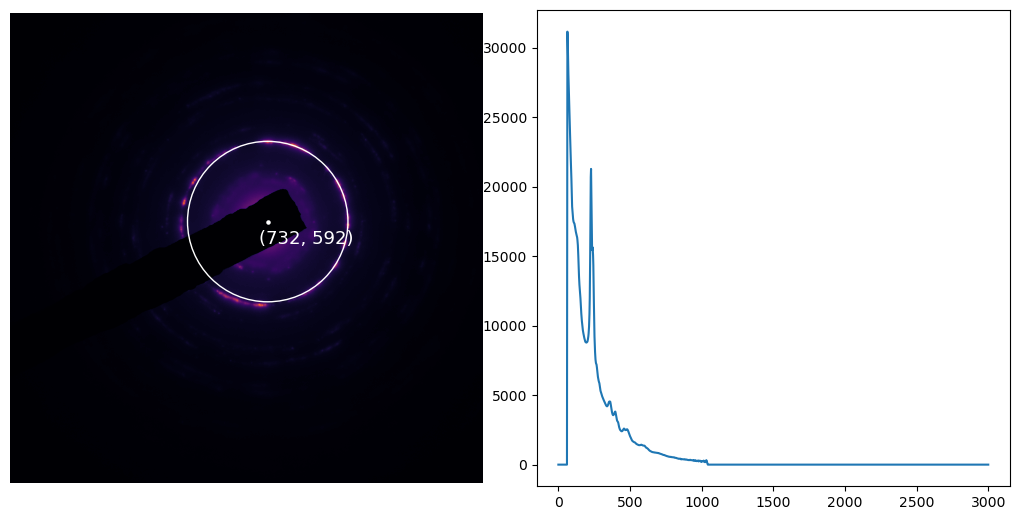

In [8]:
#Load .ser data
#directory = '/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/CDSe_Inorg_Lig'
#names = [x for x in os.listdir(directory) if x.endswith('.ser')] 

#file_path = os.path.join(directory, names[1])
#data = hs.load(file_path, signal_type='diffraction', lazy=True)
#imgs = np.array(data)
#img= imgs[0]

from matplotlib.patches import Circle
img = image_array
analysis = ImageAnalysis()
#The outputs are all 
center_x, center_y, r  = analysis.find_center(img, r = 1, #smallest radius
                                                            R = 5000, #biggest radius
                                                            threshold = 120, #threshold applied to the difratogram
                                                            edges_thresh1 = 255, #canny edge detector threshold
                                                            edges_thresh2 = 10)  #canny edge detector threshold

circle1 = Circle((center_x, center_y), r,  fill = False, color='white')

#First we mask the beamstopper on the image
processing = ImageProcessing(directory)
mask = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/ED/MASKS/feg_2.png')
img[mask == 255] = -100
binning = 3000
#The averaging does not account for the masked pixels
data, polar_img, _ = analysis.azimuth_integration_cv2(img, center = [center_x, center_y], binning=binning)


f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(img, cmap = 'inferno')
ax[0].scatter(center_x, center_y, s=5, color ='white')
ax[0].add_patch(circle1)
ax[0].axis('off')
ax[0].text(center_x+110, center_y+50, f'{center_x, center_y}', color='white', fontsize=13, ha='center', va='center')
#zoom_start = 1600
#zoom_end = 3100
#ax[0].set_xlim(zoom_start, zoom_end)
#ax[0].set_ylim(2700, 1200)  # Note: y-limits are reversed in images
ax[1].plot(data)

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout(pad=0)
plt.show()


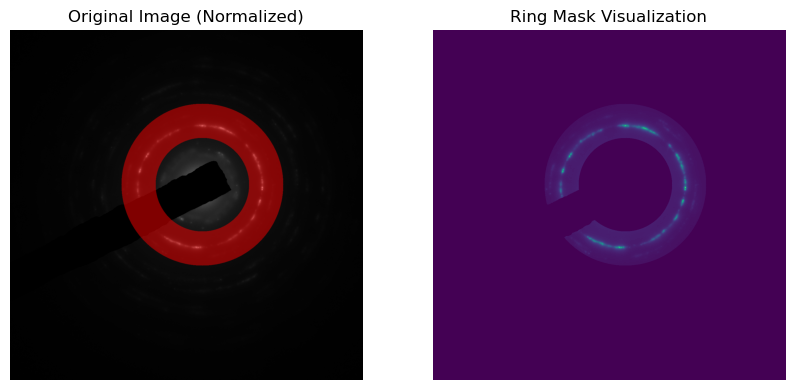

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Assume img is a NumPy array containing the grayscale image
# Example: img = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize the image to [0, 255] (if not already in that range)
img = img.astype(np.float32)  # Ensure float type for division
img -= img.min()  # Shift minimum to 0
img /= img.max()  # Normalize to [0, 1]
img *= 255  # Scale to [0, 255]
img = img.astype(np.uint8)  # Convert to uint8 format

# Get image dimensions
H, W = img.shape[:2]

# Ensure that inner_radius is smaller than outer_radius
inner_radius = max(r - 50, 0)  # Inner radius of the ring
outer_radius = r + 80  # Outer radius of the ring

# Create a coordinate grid
Y, X = np.ogrid[:H, :W]

# Compute the distance from the center
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

# Create the ring mask (values between inner and outer radius)
mask = (dist_from_center >= inner_radius) & (dist_from_center <= outer_radius)

# Apply the mask to the image
masked_image = np.zeros_like(img)
masked_image[mask] = img[mask]

# Convert the normalized grayscale image to RGB
img_rgb = np.stack([img] * 3, axis=-1)  # Convert to RGB by duplicating channels

# Create an overlay copy and apply the mask in RED
overlay_image = img_rgb.copy()
overlay_image[mask] = [255, 0, 0]  # Color the ring region red

# Blend the original and overlay for better visualization
alpha = 0.5  # Transparency factor
blended_image = cv2.addWeighted(img_rgb, 1 - alpha, overlay_image, alpha, 0)

# Display the result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(blended_image, cmap='gray')
plt.title("Original Image (Normalized)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(masked_image)
plt.title("Ring Mask Visualization")
plt.axis("off")

plt.show()


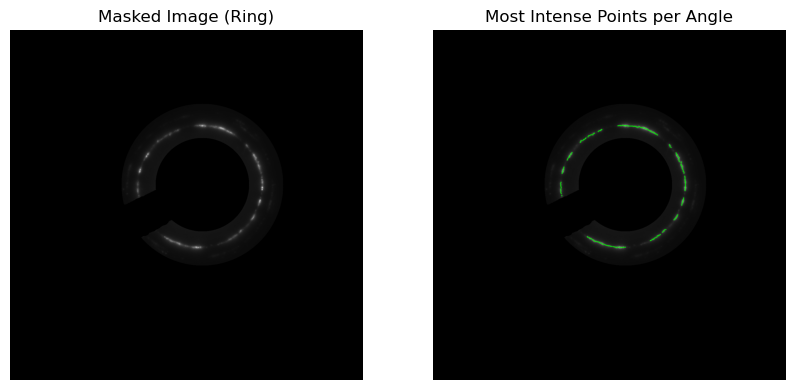

In [11]:
# Define the intensity threshold (adjust as needed)
intensity_threshold = 50  # Example threshold value

# Get image dimensions
H, W = masked_image.shape[:2]
center = (center_x, center_y)

# Define the range of angles (0° to 360° with at least 1-degree spacing)
angles = np.linspace(0, 360, 360, endpoint=False)  # 1-degree step

# Storage for max intensity points
max_intensity_points = []

# Loop through each angle
for angle in angles:
    theta = np.radians(angle)  # Convert angle to radians
    
    max_intensity = -1  # Track max intensity for this angle
    best_point = None  # Track best (x, y) point
    
    # Generate radial line from inner to outer radius
    for r in range(inner_radius, outer_radius):
        x = int(center[0] + r * np.cos(theta))
        y = int(center[1] + r * np.sin(theta))

        # Ensure the point is within image bounds
        if 0 <= x < W and 0 <= y < H:
            intensity = masked_image[y, x]  # Get pixel intensity from masked image
            
            # Only consider points above the threshold
            if intensity >= intensity_threshold and intensity > max_intensity:
                max_intensity = intensity
                best_point = (x, y, intensity)
    
    # Store the most intense point for this angle
    if best_point:
        max_intensity_points.append(best_point)

# Convert list of detected points to NumPy array
max_intensity_points = np.array(max_intensity_points)

# Visualization: Overlay detected points on the masked image
image_with_points = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)  # Convert to RGB for overlay

for (x, y, _) in max_intensity_points:
    cv2.circle(image_with_points, (x, y), 2, (0, 255, 0), -1)  # Draw points in green

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(masked_image, cmap='gray')
plt.title("Masked Image (Ring)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image_with_points)
plt.title("Most Intense Points per Angle")
plt.axis("off")

plt.show()



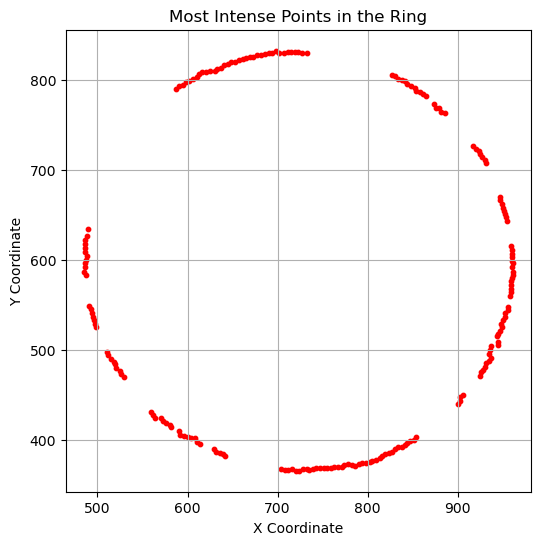

In [12]:
max_intensity_points = np.array(max_intensity_points)

# Extract x and y coordinates
x, y = max_intensity_points[:, 0], max_intensity_points[:, 1]
X,Y = x, y
# Scatter plot of the points
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='red', marker='o', s=10)  # Red points
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Most Intense Points in the Ring")
plt.axis("equal")  # Ensure equal aspect ratio
plt.grid(True)

# Show the scatter plot
plt.show()



In [13]:
# Convert to float
x = x.astype(float)
y = y.astype(float)

# ✅ Step 1: Center and Normalize Data
x_mean, y_mean = x.mean(), y.mean()
x -= x_mean
y -= y_mean

x_scale = np.std(x)
y_scale = np.std(y)

x /= x_scale
y /= y_scale

In [14]:
import numpy as np
import matplotlib.pyplot as plt


D = np.column_stack((x**2, x*y, y**2, x, y, np.ones_like(x)))

U, S, Vt = np.linalg.svd(D)
ellipse_params = Vt[-1, :]  # Last row gives the best fit solution

# ✅ Step 3: Extract ellipse coefficients
A, B, C, D, E, F = ellipse_params


/tmp/ipykernel_483039/717242990.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, Z_grid, levels=[0], colors='r', linewidths=2, label="Rescaled Ellipse")


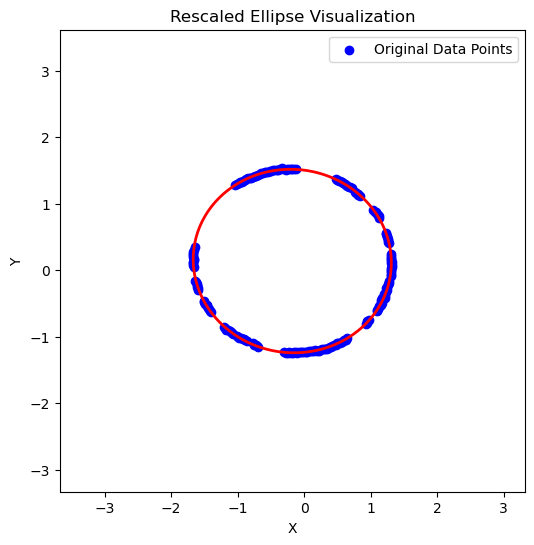

In [15]:
x_range = np.linspace(min(x) - 2, max(x) + 2, 400)
y_range = np.linspace(min(y) - 2, max(y) + 2, 400)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

# Compute the ellipse function Z(x, y) = Ax² + Bxy + Cy² + Dx + Ey + F
Z_grid = (A * X_grid**2 + B * X_grid * Y_grid + 
          C * Y_grid**2 + D * X_grid + 
          E * Y_grid + F)

# Plot the original data points
plt.figure(figsize=(6,6))
plt.scatter(x, y, label="Original Data Points", color="blue")

# Plot the rescaled ellipse as a contour where Z = 0
plt.contour(X_grid, Y_grid, Z_grid, levels=[0], colors='r', linewidths=2, label="Rescaled Ellipse")

plt.legend()
plt.axis("equal")
plt.title("Rescaled Ellipse Visualization")
plt.xlabel("X")
plt.ylabel("Y")

# Show the plot
plt.show()


/tmp/ipykernel_483039/3970165122.py:22: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, Z_grid, levels=[0], colors='r', linewidths=2, label="Fitted Ellipse")


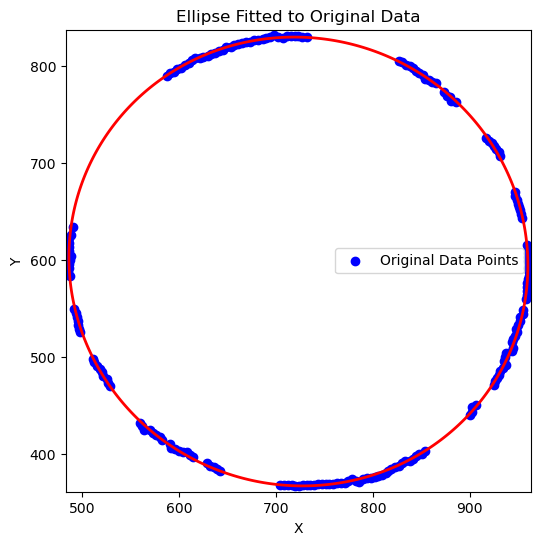

In [16]:
A_rescaled = A / x_scale**2
B_rescaled = B / (x_scale * y_scale)
C_rescaled = C / y_scale**2

D_rescaled = (D / x_scale) - 2 * A_rescaled * x_mean - B_rescaled * y_mean
E_rescaled = (E / y_scale) - 2 * C_rescaled * y_mean - B_rescaled * x_mean

F_rescaled = (F - (A_rescaled * x_mean**2 + B_rescaled * x_mean * y_mean +
                   C_rescaled * y_mean**2 + D_rescaled * x_mean + E_rescaled * y_mean))

X_range = np.linspace(min(X) - 2, max(X) + 2, 600)
Y_range = np.linspace(min(Y) - 2, max(Y) + 2, 600)
X_grid, Y_grid = np.meshgrid(X_range, Y_range)

Z_grid = (A_rescaled * X_grid**2 + B_rescaled * X_grid * Y_grid +
          C_rescaled * Y_grid**2 + D_rescaled * X_grid +
          E_rescaled * Y_grid + F_rescaled)

plt.figure(figsize=(6,6))
plt.scatter(X, Y, label="Original Data Points", color="blue")

plt.contour(X_grid, Y_grid, Z_grid, levels=[0], colors='r', linewidths=2, label="Fitted Ellipse")

plt.legend()
plt.axis("equal")
plt.title("Ellipse Fitted to Original Data")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()


In [65]:
M = np.array([[A_rescaled, B_rescaled], 
              [B_rescaled, C_rescaled]])

eigvals, eigvecs = np.linalg.eig(M)

lambda_min, lambda_max = np.min(np.abs(eigvals)), np.max(np.abs(eigvals))
a = 1 / lambda_min**(1/2)
b = 1 / lambda_max**(1/2)

if a < b:
    a, b = b, a  

ellipticity = 1 - (b / a)
theta_deg = np.degrees(0.5 * np.arctan2(B_rescaled, (A_rescaled - C_rescaled)))

print(f"Semi-Major Axis: {a:.4f}")
print(f"Semi-Minor Axis: {b:.4f}")
print(f"Ellipticity: {ellipticity:.4f}")
print(f"Rotation Angle: {theta_deg:.2f}°")

Semi-Major Axis: 263.8797
Semi-Minor Axis: 252.8583
Ellipticity: 0.0418
Rotation Angle: 70.51°


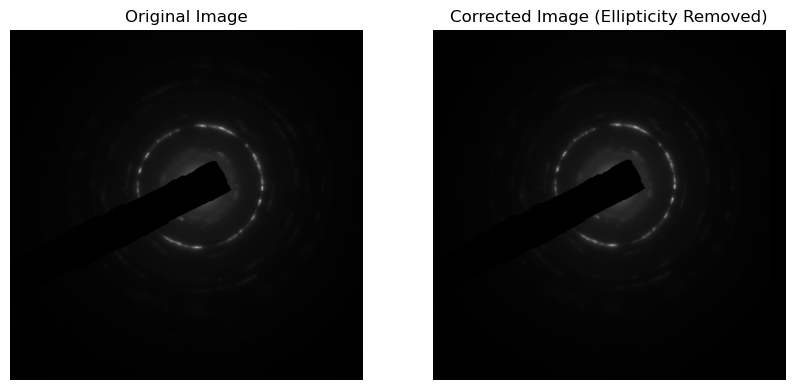

In [66]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
theta_deg = 0
# Compute transformation parameters
theta_rad = np.radians(theta_deg)
cos_t, sin_t = np.cos(theta_rad), np.sin(theta_rad)

# First Rotation: Align the Ellipse
rotation_matrix1 = np.array([[cos_t, -sin_t], [sin_t, cos_t]])

# Scaling: Normalize Ellipticity
scaling_matrix = np.array([[b/a, 0], [0, 1]])  # Corrects the major axis

# Final Rotation: Restore Original Orientation
rotation_matrix2 = np.array([[cos_t, sin_t], [-sin_t, cos_t]])


scaling_matrix1 = np.array([[1, 0], [0, 0.99]])

# Compute Final Transformation Matrix (2×2)
transform_matrix = rotation_matrix2 @ scaling_matrix @ rotation_matrix1 @ scaling_matrix1

# Convert to 2×3 Affine Matrix by Adding a Translation Column
M_affine = np.hstack([transform_matrix, np.array([[0], [0]])])  # Ensure shape is (2,3)
M_affine = M_affine.astype(np.float32)  # OpenCV requires float32 or float64

# Get Image Size
H, W = img.shape[:2]
img_copy = img.copy()
# Apply Warp
corrected_img = cv2.warpAffine(img_copy, M_affine, (W, H), flags=cv2.INTER_LINEAR)

# Display Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(corrected_img, cmap='gray')
plt.title("Corrected Image (Ellipticity Removed)")
plt.axis("off")

plt.show()


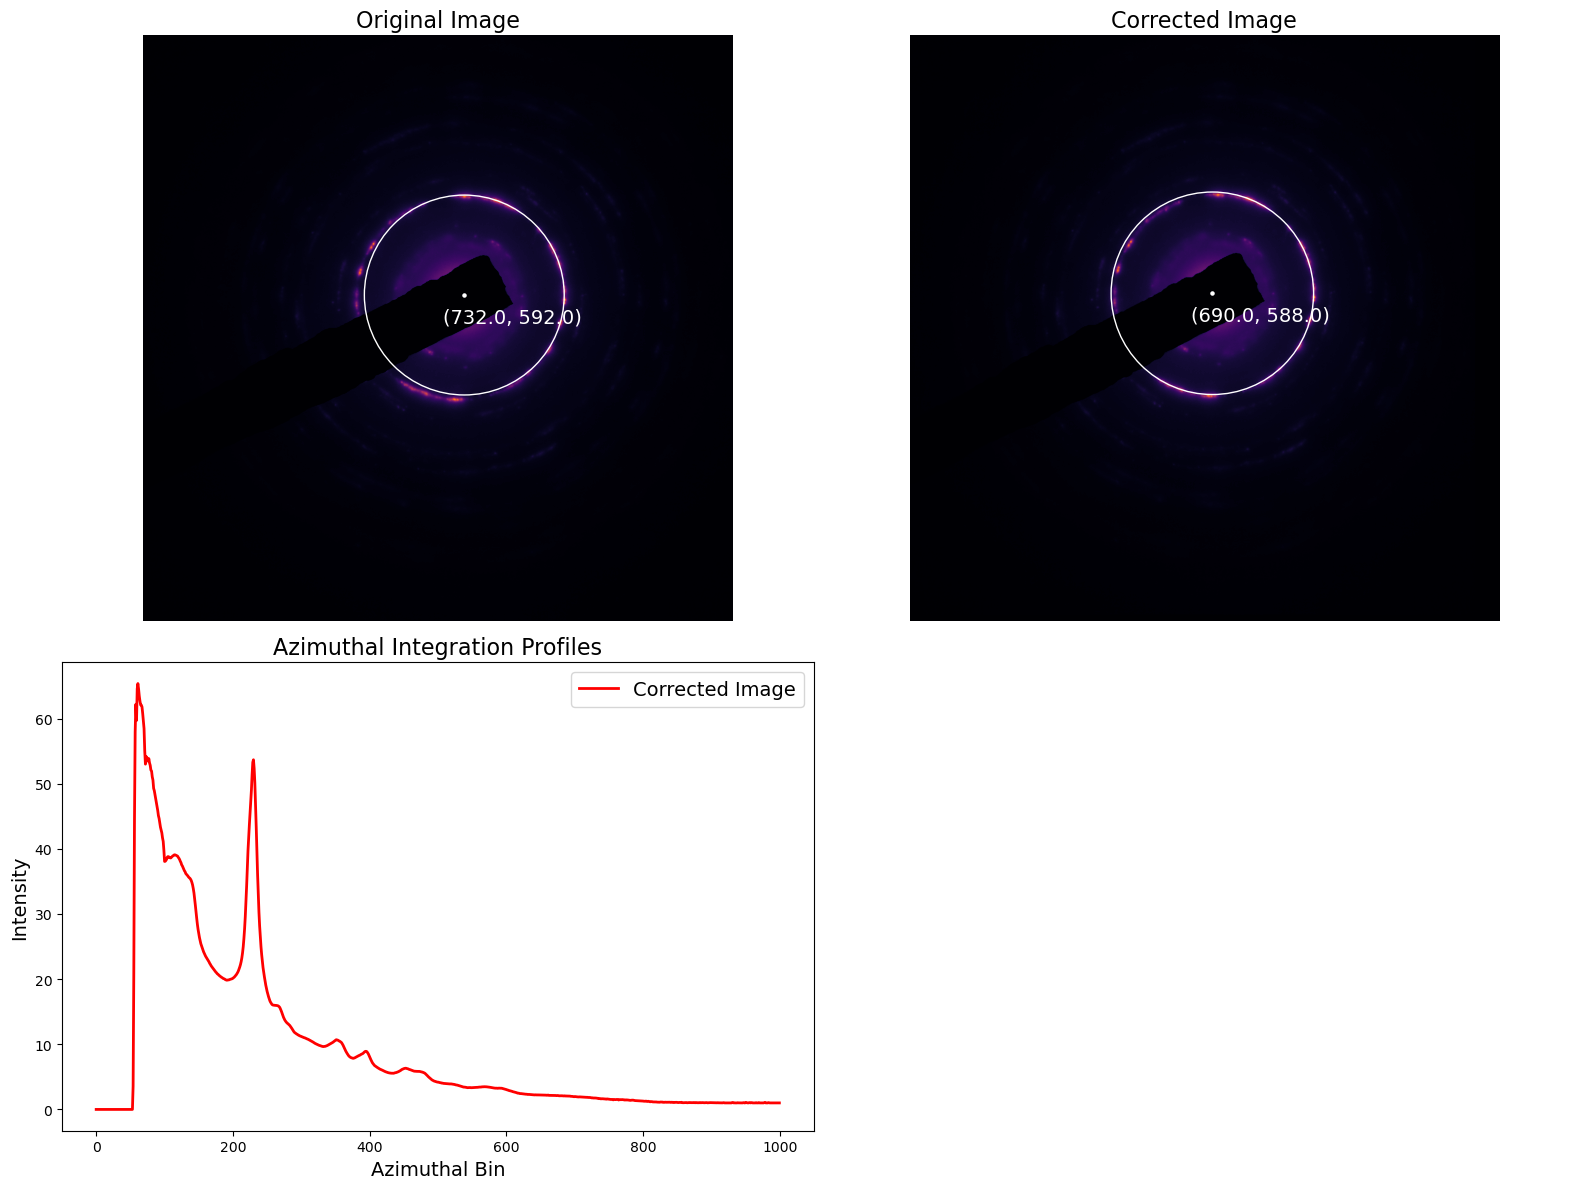

In [64]:
analysis = ImageAnalysis()

center_x_img, center_y_img, r_img = analysis.find_center(
    img, r=1, R=5000, threshold=120, edges_thresh1=255, edges_thresh2=10
)

center_x_corr, center_y_corr, r_corr = analysis.find_center(
    corrected_img, r=1, R=5000, threshold=110, edges_thresh1=255, edges_thresh2=10
)

circle_img = Circle((center_x_img, center_y_img), r_img, fill=False, color='white')
circle_corr = Circle((center_x_corr, center_y_corr), r_corr, fill=False, color='white')

processing = ImageProcessing(directory)
mask = processing.load_mask('/home/ABTLUS/victor.secco/data_processing/ED/MASKS/mask_titan.tif')

binning = 1000

data_img, _, _ = analysis.azimuth_integration_cv2(img, center=[center_x_img, center_y_img], binning=binning)
data_corr, _, _ = analysis.azimuth_integration_cv2(corrected_img, center=[center_x_corr, center_y_corr], binning=binning)

fig, ax = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'height_ratios': [1, 0.8]})

ax[0, 0].imshow(img, cmap='inferno')
ax[0, 0].scatter(center_x_img, center_y_img, s=5, color='white')
ax[0, 0].add_patch(circle_img)
ax[0, 0].axis('off')
ax[0, 0].text(center_x_img + 110, center_y_img + 50, f'({center_x_img:.1f}, {center_y_img:.1f})', color='white', fontsize=14, ha='center', va='center')
#ax[0, 0].set_xlim(1600, 3100)
#ax[0, 0].set_ylim(2700, 1200)
ax[0, 0].set_title("Original Image", fontsize=16)

ax[0, 1].imshow(corrected_img, cmap='inferno')
ax[0, 1].scatter(center_x_corr, center_y_corr, s=5, color='white')
ax[0, 1].add_patch(circle_corr)
ax[0, 1].axis('off')
ax[0, 1].text(center_x_corr + 110, center_y_corr + 50, f'({center_x_corr:.1f}, {center_y_corr:.1f})', color='white', fontsize=14, ha='center', va='center')
#ax[0, 1].set_xlim(1600, 3100)
#ax[0, 1].set_ylim(2700, 1200)
ax[0, 1].set_title("Corrected Image", fontsize=16)

#ax[1, 0].plot(data_img, label="Original Image", color="blue", linewidth=2)
ax[1, 0].plot(data_corr, label="Corrected Image", color="red",  linewidth=2)
ax[1, 0].set_xlabel("Azimuthal Bin", fontsize=14)
ax[1, 0].set_ylabel("Intensity", fontsize=14)
ax[1, 0].legend(fontsize=14)
ax[1, 0].set_title("Azimuthal Integration Profiles", fontsize=16)

ax[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [63]:
processing.save_iq_only_y(data_corr, (os.path.join(os.path.dirname(directory), 'Mno')))